In [1]:
import tensorflow as tf
import keras
import numpy as np
import time
import random
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Activation, Flatten, LSTM, GRU, SimpleRNN, Conv2D, MaxPooling2D, Flatten, Dropout, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.regularizers import l2, l1, l1_l2
from collections import deque

from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error as mse
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow import keras
from matplotlib import pyplot as plt
from IPython.display import clear_output

import qkeras
from qkeras import *

import hls4ml
import pickle


2022-06-21 10:35:00.405450: I tensorflow/core/util/util.cc:168] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-06-21 10:35:00.410058: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-21 10:35:00.410071: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


name convert optimizers ['fuse_bias_add', 'remove_useless_transpose', 'output_rounding_saturation_mode', 'qkeras_factorize_alpha', 'extract_ternary_threshold', 'fuse_consecutive_batch_normalization'] File: flow.py Line: 23
name optimize optimizers ['eliminate_linear_activation', 'fuse_consecutive_batch_normalization', 'fuse_batch_normalization', 'replace_multidimensional_dense_with_conv'] File: flow.py Line: 23
vivado:merge_batch_norm_quantized_tanh Get_Optimizer, optimizer/optimizer.py ligne: 168
vivado:quantize_dense_output Get_Optimizer, optimizer/optimizer.py ligne: 168
vivado:batchnormalizationquantizedtanh_config_template Get_Optimizer, optimizer/optimizer.py ligne: 168
vivado:batchnormalizationquantizedtanh_function_template Get_Optimizer, optimizer/optimizer.py ligne: 168
vivado:clone_output Get_Optimizer, optimizer/optimizer.py ligne: 168
vivado:clone_function_template Get_Optimizer, optimizer/optimizer.py ligne: 168
vivado:optimize_pointwise_conv Get_Optimizer, optimizer/opti

/atlas/bonnet/hls4ml/hls4ml/hls4ml/hls4ml/converters/__init__.py:15: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!")


In [2]:
from nnlar.datashaper import DataShaper
ds = DataShaper.from_h5("../data/rdgap_mu140.h5")

x, x_val, x_test, y, y_val, y_test = ds()

shapes (1999995, 5, 1) (1999995, 1)
shapes (899992, 5, 1) (99995, 5, 1) (999998, 5, 1)


In [3]:
boosted_model =  tf.keras.models.load_model('../pb_file')

boosted_model.summary()


2022-06-21 10:35:05.700511: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-21 10:35:05.700570: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-21 10:35:05.700612: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (martop): /proc/driver/nvidia/version does not exist
2022-06-21 10:35:05.701322: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 8)                 80        
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________


In [4]:
# settings of the networks 
output = 1

nbr_batch = 64
nbr_epoch = 200
lr=0.001

time_step = 5
nbr_conv_epoch = 70 #number of epochs for the conversion 

weight_decay=0.00000001
patience_es = 12
patience_rlr = 3
delta = 0.00000001
regularizer = l2

def version(v): return (v)
versions_range = 4 

def units(j): return (j+8)
units_range = 1

In [5]:
integer = 0

def bit_lenghts(i):
    #To change to create models with different bits parameter by defining the smallest bit lenghts 
    #Example : bits 8 ==> (i+4)*4
    return (i+1)*2

def bit_width(i): return {'bits': (i+1)*2, 'integer': integer, 'symmetric': 0, 'alpha':1}

rest_array = [8,10,12]
rest_units_range =  3
bits_range = 7

In [6]:
# path

#path of the tested models 
def models_path(v) : return f"tests/models/optimized_model.h5" 
def predicts_path(v) : return f"tests/predicts/optimized_model.npy" 

#path of the qconverted models
def qmodels_path0(i, v, k): return f"tests/qmodels/qmodels_conv_patiencES={patience_es}_patienceRLR={patience_rlr}_mindelta{delta},rkernel<{bit_lenghts(i)},{integer}>_rest={rest_array[k]}_v{version(v)}.h5"
def qpredicts_path0(i, v, k): return f"tests/qpredicts/qmodels_conv_patiencES={patience_es}_patienceRLR={patience_rlr}_mindelta{delta},rkernel<{bit_lenghts(i)},{integer}>_rest={rest_array[k]}_v{version(v)}.npy"
def qhist_path(i,v,k): return f"tests/qhist/qmodels_conv_patiencES={patience_es}_patienceRLR={patience_rlr}_mindelta{delta},rkernel<{bit_lenghts(i)},{integer}>_rest={rest_array[k]}_v{version(v)}.pkl"

def qmodels_path1(i): return f"tests/qmodels/qmodels_conv_patiencES={patience_es}_patienceRLR={patience_rlr}_mindelta{delta},rkernel<{bit_lenghts(i)},{integer}>_rest=10.h5"
def qpredicts_path1(i, v, k): return f"tests/qpredicts_240/qmodels_conv_patiencES={patience_es}_patienceRLR={patience_rlr}_mindelta{delta},rkernel<{bit_lenghts(i)},{integer}>_rest={rest_array[k]}_v{version(v)}.npy"

def qmodels_path2(i): return f"tests/qmodels/qmodels_conv_patiencES={patience_es}_patienceRLR={patience_rlr}_mindelta{delta},rkernel<{bit_lenghts(i)},{integer}>_rest=12.h5"
def qpredicts_path2(i): return f"tests/qpredicts/qmodels_conv_patiencES={patience_es}_patienceRLR={patience_rlr}_mindelta{delta},rkernel<{bit_lenghts(i)},{integer}>_rest=12.npy"


#path of the qtrained models
def qtrained_models_path(j, i): return f"tests/qmodels_test/qtrained/qmodels_units={units(j)}_epoch={nbr_epoch}_batch={nbr_batch}_lr={lr},<{bit_lenghts(i)},{integer}>.h5"
def qtrained_predicts_path(j, i):  return f"tests/qpredicts_test/qtrained/qmodels_units={units(j)}_epoch={nbr_epoch}_batch={nbr_batch}_lr={lr},<{bit_lenghts(i)},{integer}>.npy"

#path of the qref models 
def qrefmodels_path (i) : return f"qmodels_epoch={nbr_conv_epoch}/qmodels<{bit_lenghts(i)},{integer}>.h5"
def qrefpredicts_path (i) : return f"qpredicts_epoch={nbr_conv_epoch}/qpredicts<{bit_lenghts(i)},{integer}>.npy"

In [7]:
def exist(path,modeltopred):
    if (os.path.exists(path)==False):
        np.save(path, modeltopred.predict(x_test))
     
    else : print(f'{path} already exists')
def exist_std(path,modeltopred):
    cut_indices = np.where(y_test > 0.24/16)[0]
    if (os.path.exists(path)==False):
        np.save(path, modeltopred.predict(x_test[cut_indices]))
     
    else : print(f'{path} already exists')

# Auto qkeras tests


In [8]:
from qkeras.utils import model_quantize
from qkeras.qtools import run_qtools
from qkeras import autoqkeras
from qkeras.qtools import settings as qtools_settings

In [9]:
quantization_config = {
        "kernel": {
                "quantized_bits(2,1,1,alpha=1.0)": 2,
                "quantized_bits(4,0,1,alpha=1.0)": 4,
                "quantized_bits(6,0,1,alpha=1.0)": 6,
                "quantized_bits(8,0,1,alpha=1.0)": 8,
                "quantized_bits(10,0,1,alpha=1.0)": 10,
                "quantized_bits(12,0,1,alpha=1.0)": 12,
                "quantized_po2(8,1)": 8
        },
        "bias": {
                "quantized_bits(2,1,1,alpha=1.0)": 2,
                "quantized_bits(4,0,1,alpha=1.0)": 4,
                "quantized_bits(6,0,1,alpha=1.0)": 6,
                "quantized_bits(8,0,1,alpha=1.0)": 8,
                "quantized_bits(10,0,1,alpha=1.0)": 10,
                "quantized_bits(12,0,1,alpha=1.0)": 12,
                "quantized_po2(8,0)": 8
        },
        "activation": {
                "quantized_relu_po2(8,0)": 8,
                "quantized_relu(2,0)": 2,
                "quantized_relu(4,0)": 4,
                "quantized_relu(6,0)": 6,
                "quantized_relu(8,0)": 8,
                "quantized_relu(10,0)": 10,
                "quantized_relu(12,0)": 12,
                "quantized_relu(14,0)": 14
        },
        "linear": {
                 "quantized_bits(2,1,1,alpha=1.0)": 2,
                "quantized_bits(4,0,1,alpha=1.0)": 4,
                "quantized_bits(6,0,1,alpha=1.0)": 6,
                "quantized_bits(8,0,1,alpha=1.0)": 8,
                "quantized_bits(10,0,1,alpha=1.0)": 10,
                "quantized_bits(12,0,1,alpha=1.0)": 12
        }
}

In [10]:
goal = {
    "type": "energy",
    "params": {
        "delta_p": 8.0,
        "delta_n": 8.0,
        "rate": 2.0,
        "stress": 1.0,
        "process": "horowitz",
        "parameters_on_memory": ["sram", "sram"],
        "activations_on_memory": ["sram", "sram"],
        "rd_wr_on_io": [False, False],
        "min_sram_size": [0, 0],
        "source_quantizers": ["int8"],
        "reference_internal": "int8",
        "reference_accumulator": "int32"
        }
}

model =tf.keras.models.load_model(models_path(0)) 


In [11]:
limit = {
    "SimpleRNN": [6, 6, 6, 6],
    "Dense": [16, 16, 16],
    "BatchNormalization": [],
    "Activation": [12]
}

In [12]:
tempfile = "tests/tmp"

run_config = {
    "output_dir": tempfile,
 "goal": goal,
  "quantization_config": quantization_config,
  "learning_rate_optimizer": False,
  "transfer_weights": False,
  "mode": "random",
  "seed": 42,
  "limit": limit,
  "tune_filters": "layer",
  "layer_indexes": range(1, len(model.layers) - 1),
  "max_trials": 20
}




In [13]:
autoqk = qkeras.autoqkeras.AutoQKeras(model, **run_config)
autoqk.fit(x, y, validation_data=(x_test, y_test), batch_size=64, epochs=20)


operation count for <keras.layers.rnn.simple_rnn.SimpleRNN object at 0x7f33e44e5bd0> is defaulted to 0
Limit configuration:{"QSimpleRNN": [6, 6, 6, 6], "Dense": [16, 16, 16], "BatchNormalization": [], "Activation": [12]}


[WARNING] QTools cannot parse SimpleRNN. The input quatnizer of this layer is directly passed through to the output!


TypeError: first argument must be string or compiled pattern

In [ ]:
from qkeras.autoqkeras import *

qmodel = autoqk.get_best_model()
qmodel.save_weights("qmodel.h5")

AttributeError: module 'qkeras.autoqkeras' has no attribute 'get_best_model'

In [ ]:
model = tf.keras.models.load_model(models_path(0))      
exist(predicts_path(0), model)
ref = 'tests/ref_predicts.npy'
exist(ref, boosted_model)
std_ref = 'tests/std_ref_predicts.npy'
exist_std(std_ref, boosted_model)

for i in range(bits_range):
    for v in range (versions_range):
        for k in range (rest_units_range):

            qmodel0 = qkeras.utils.load_qmodel(qmodels_path0(i,v,k))        
            exist_std(qpredicts_path1(i,v,k), qmodel0)

"""
    qmodel1 = qkeras.utils.load_qmodel(qmodels_path1(i))        
    exist(qpredicts_path1(i), qmodel1)

    
    qmodel2 = qkeras.utils.load_qmodel(qmodels_path2(i))        
    exist(qpredicts_path2(i), qmodel2)
    qmodel3 = qkeras.utils.load_qmodel(qmodels_path3(i))        
    exist(qpredicts_path3(i), qmodel3)"""
    




OSError: No file or directory found at tests/models/optimized_model.h5

In [ ]:
print(qpredicts_path0(2,1,2))

tests/qpredicts/qmodels_conv_patiencES=12_patienceRLR=3_mindelta1e-08,rkernel<6,0>_rest=12_v1.npy


In [ ]:
y_model=qkeras.utils.load_qmodel(qmodels_path0(2,1,2))
qkeras.utils.model_save_quantized_weights(y_model, "tests/weights/quantizedweights.h5")

y_model.load_weights("tests/weights/quantizedweights.h5")

y_model.save("tests/quantizedmodel.h5")

y_keras2 = np.load(qpredicts_path0(2,1,2))

print(mse(y_test,y_keras2))

... quantizing model
9.943244e-06


In [ ]:
y_keras0 = np.loadtxt("../out-c1.txt")
print(y_keras0.shape)
print(mse(y_test,np.load(ref)))
MSETIENNE = mse(y_test[:999992],y_keras0[2:])
print(MSETIENNE)


(999994,)
9.775778e-06
9.776478000410742e-06


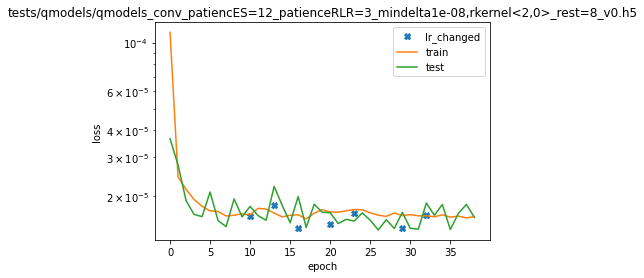

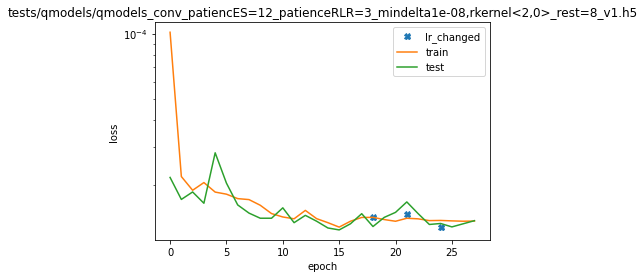

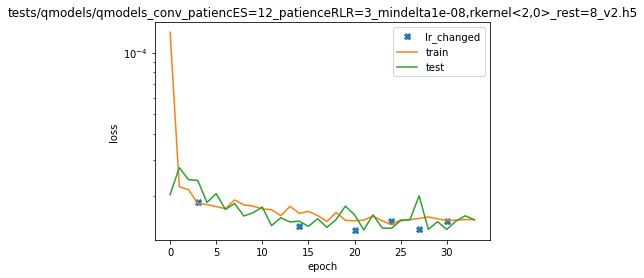

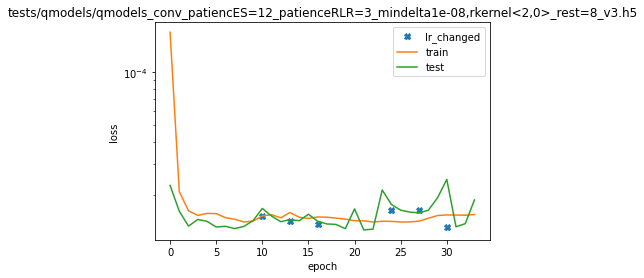

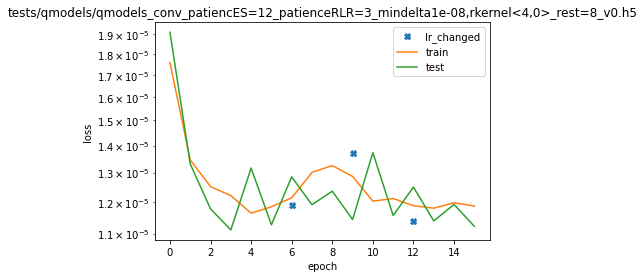

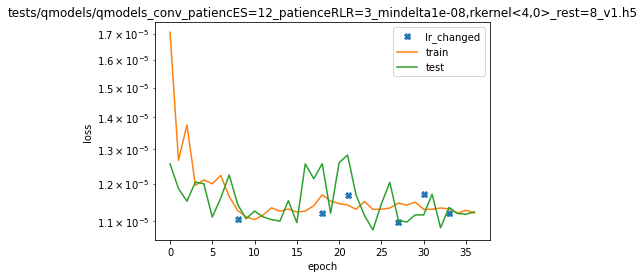

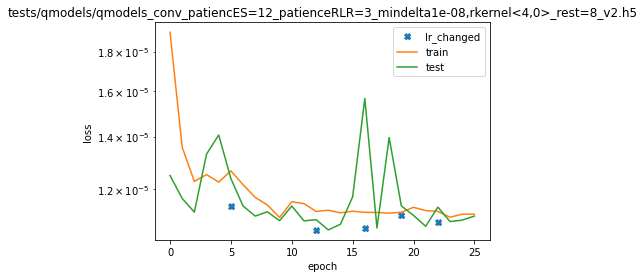

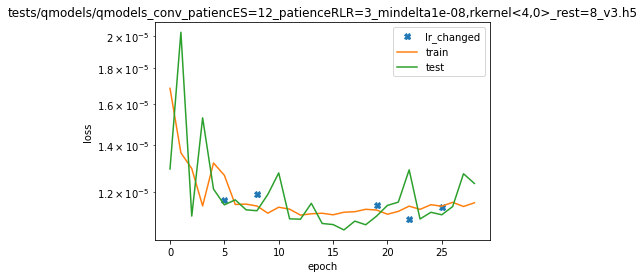

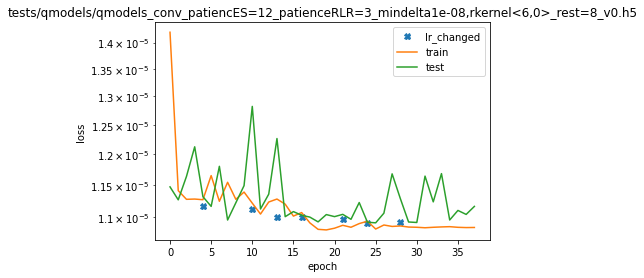

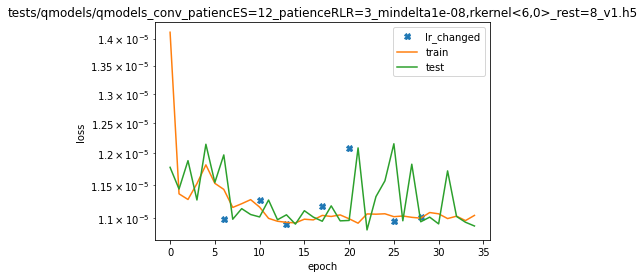

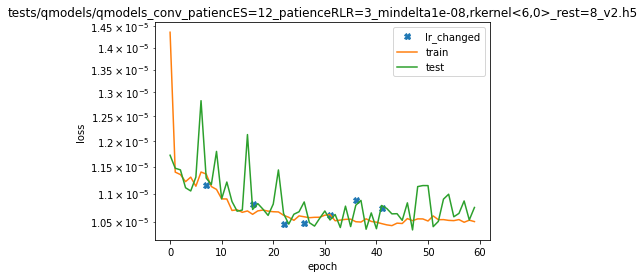

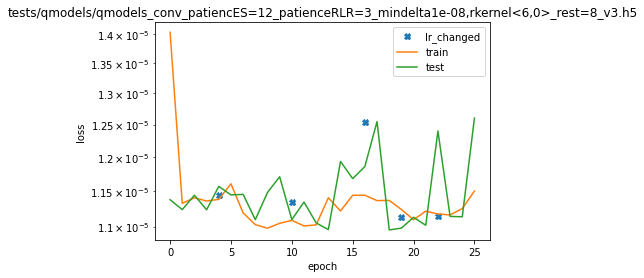

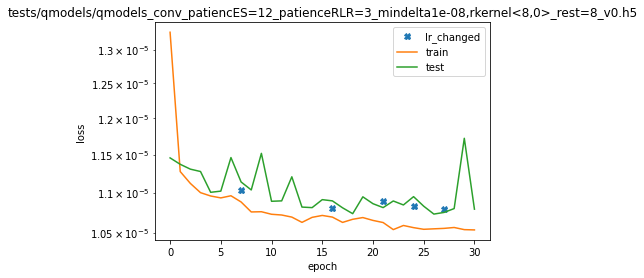

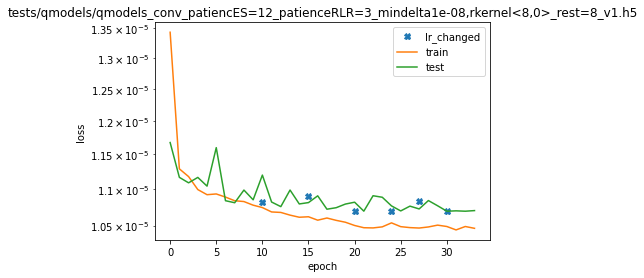

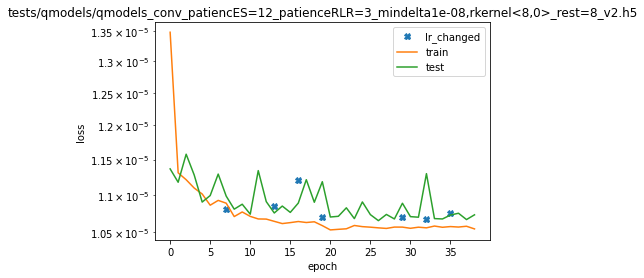

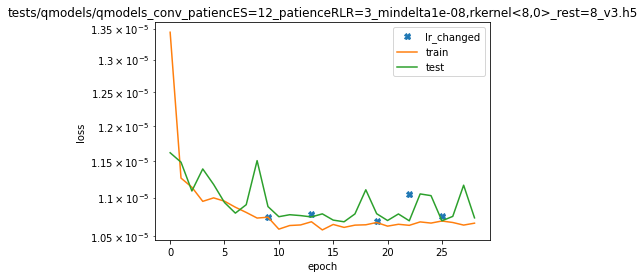

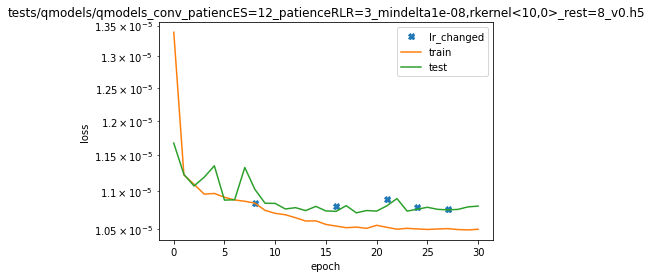

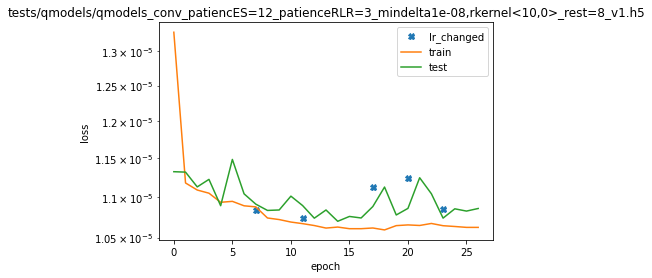

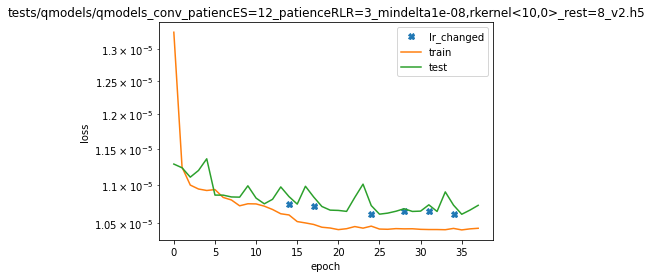

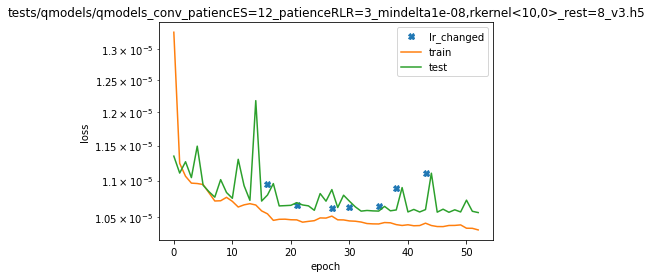

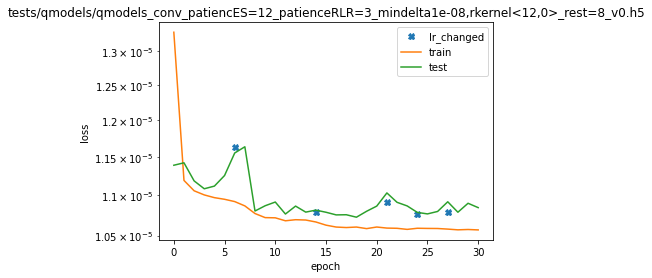

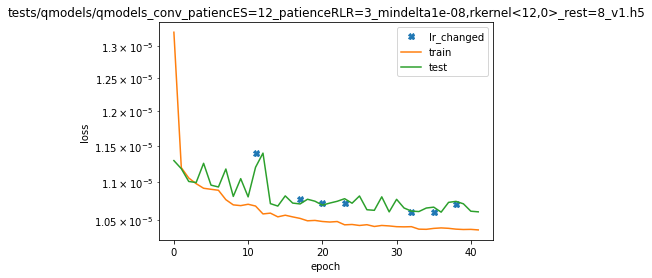

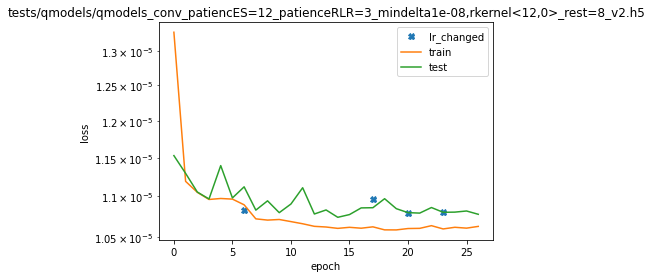

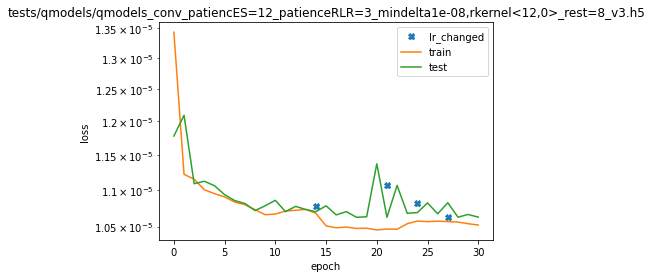

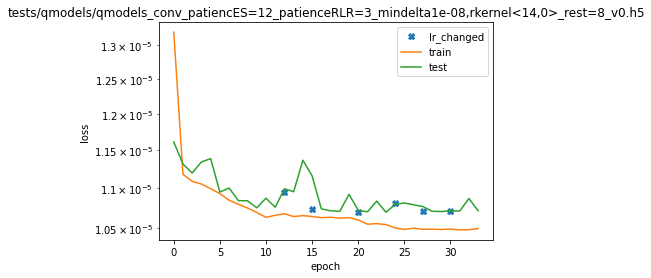

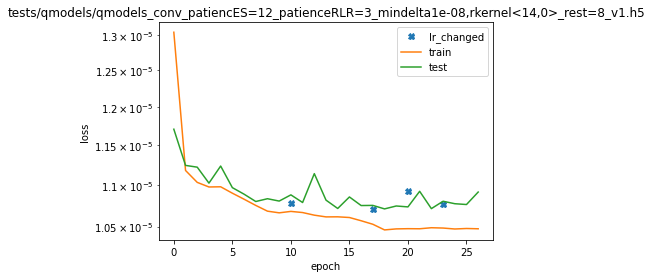

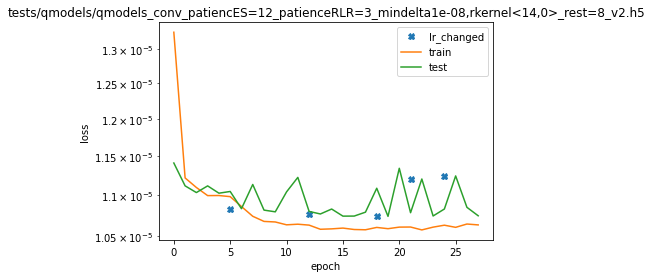

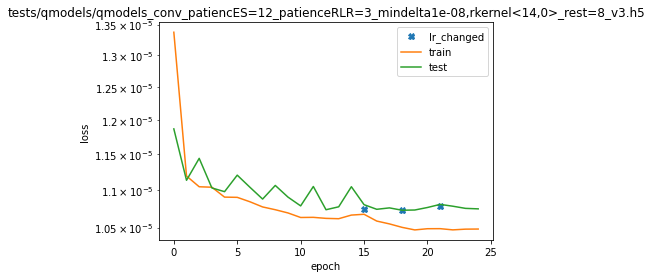

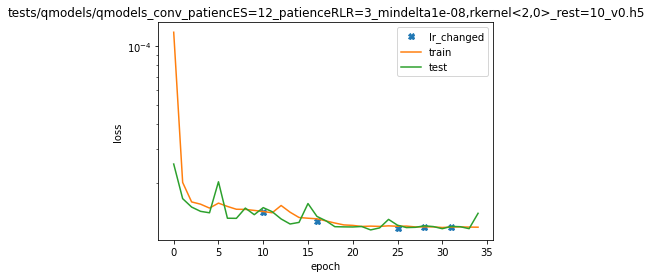

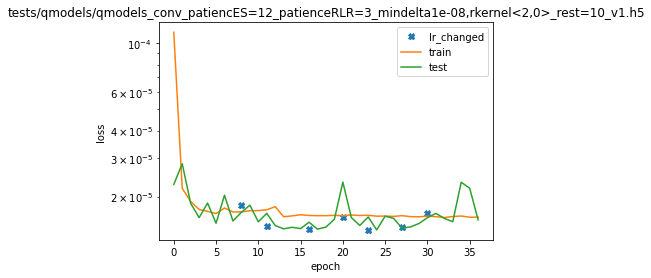

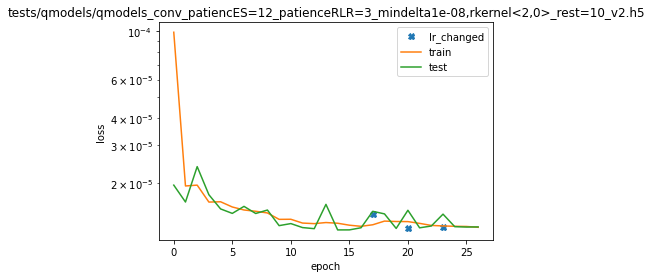

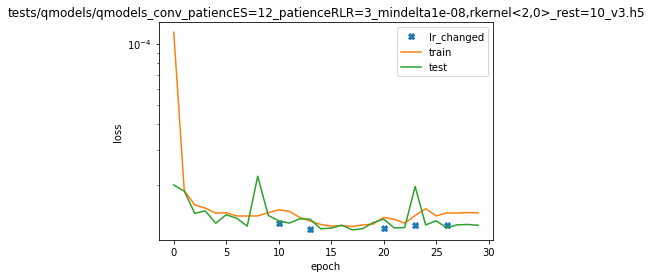

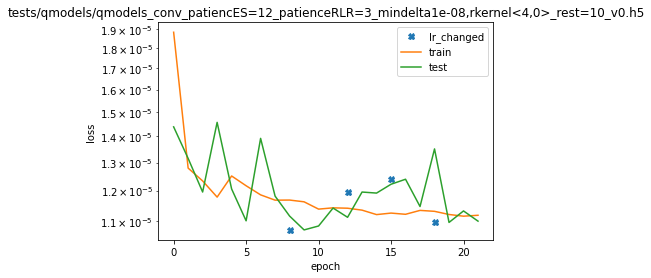

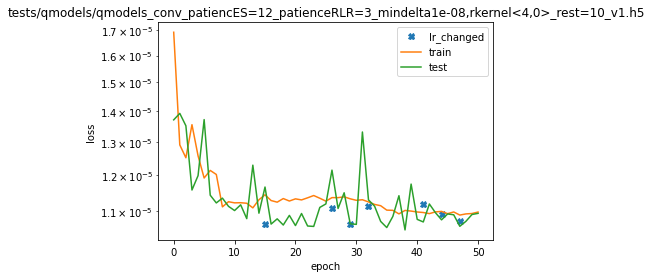

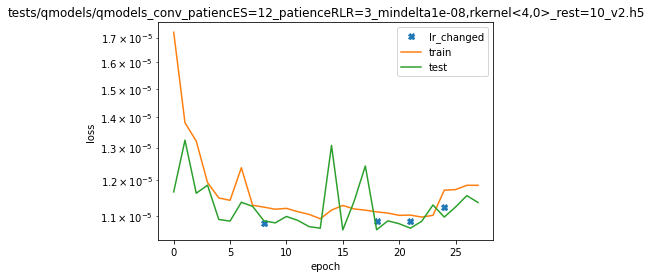

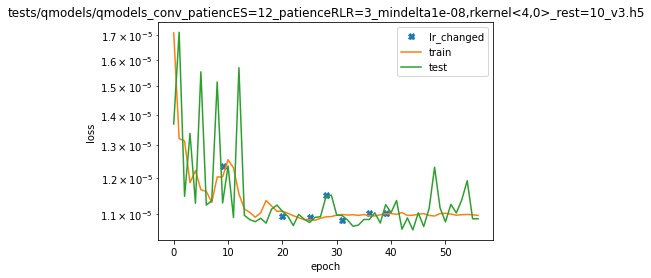

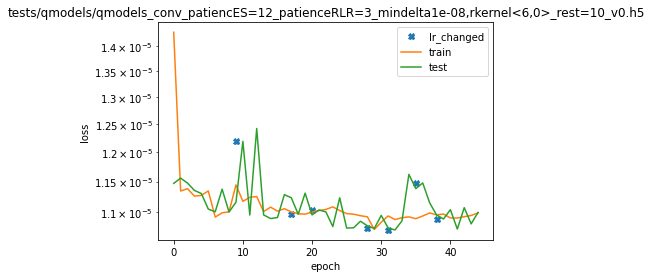

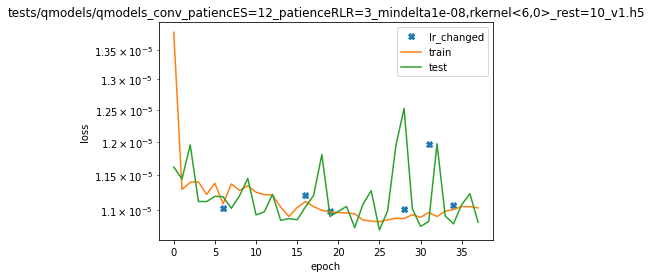

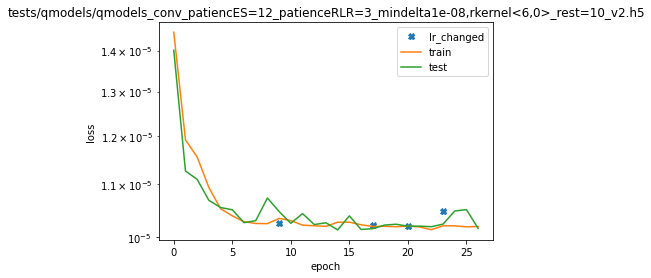

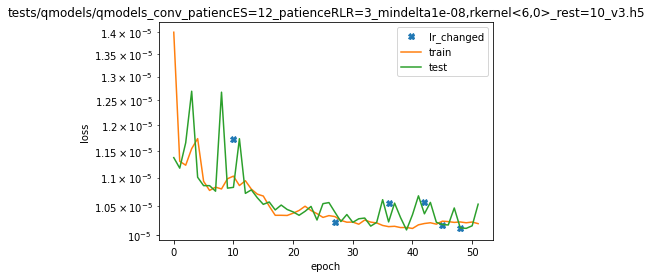

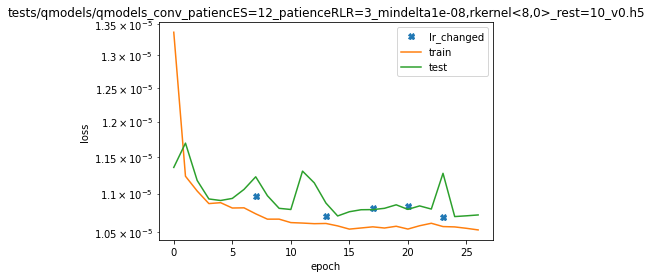

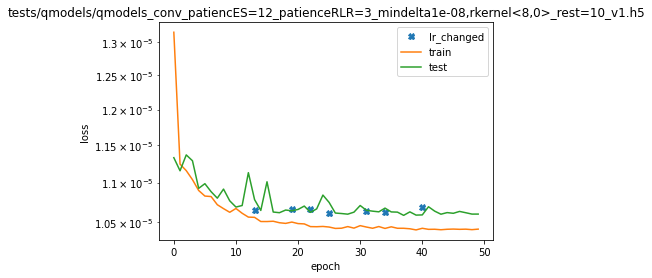

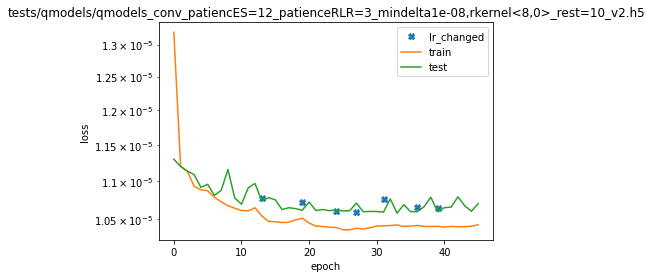

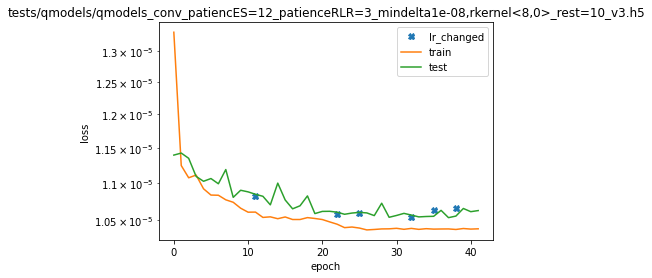

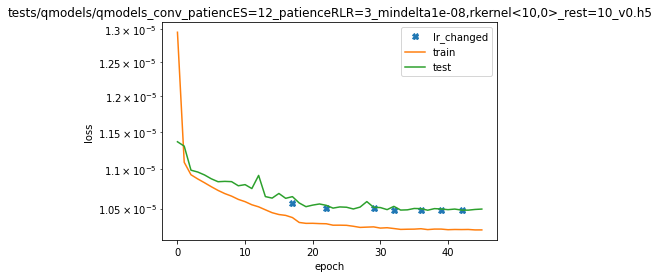

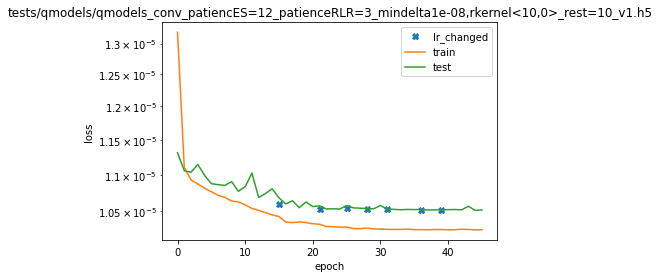

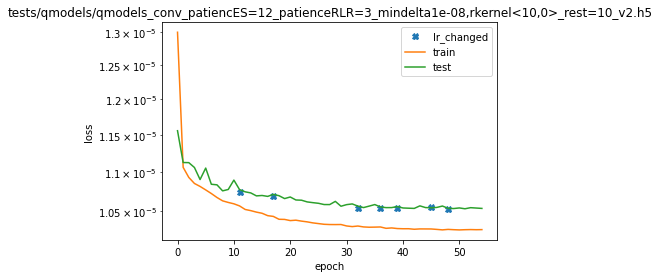

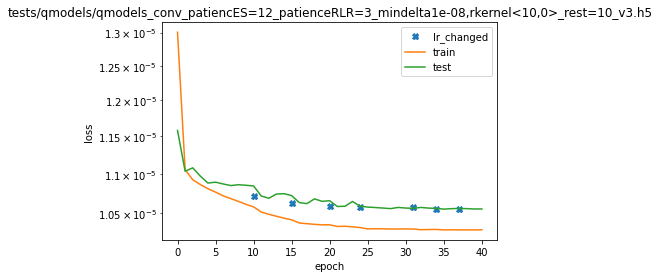

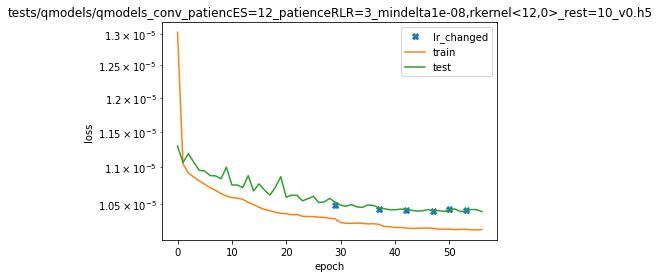

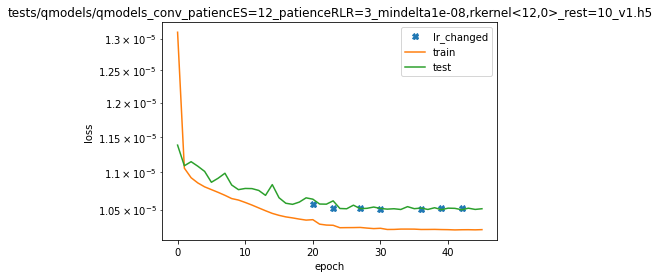

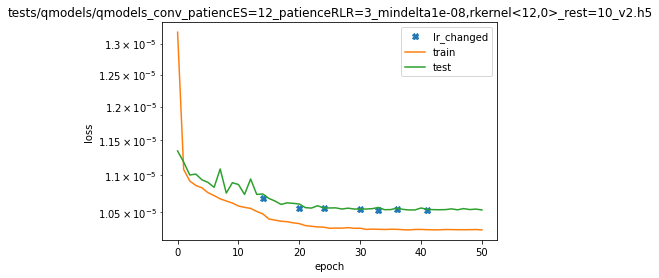

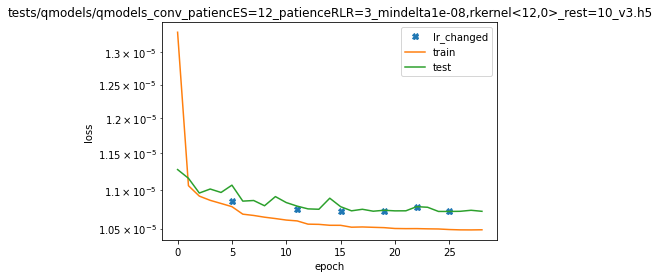

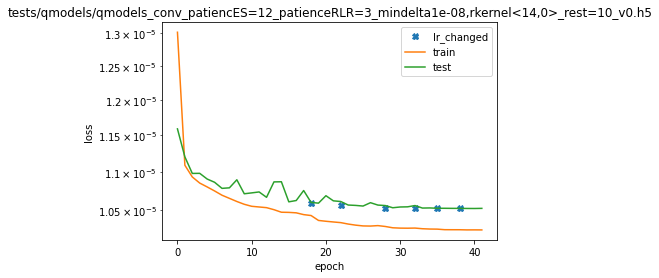

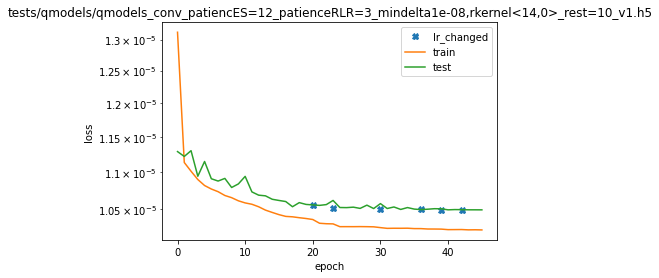

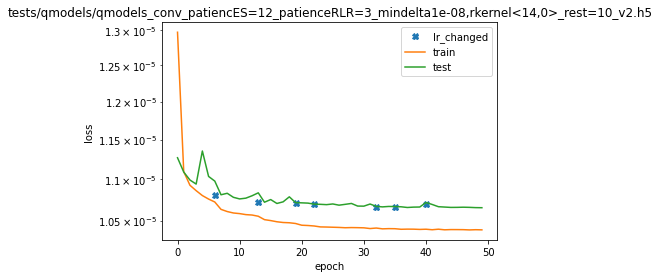

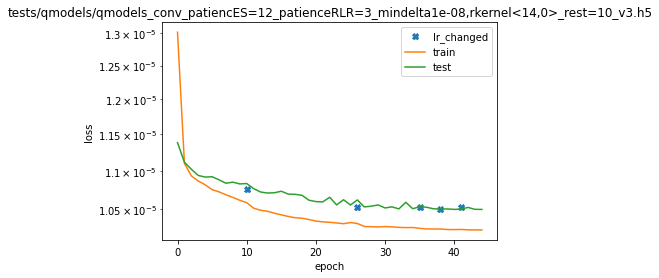

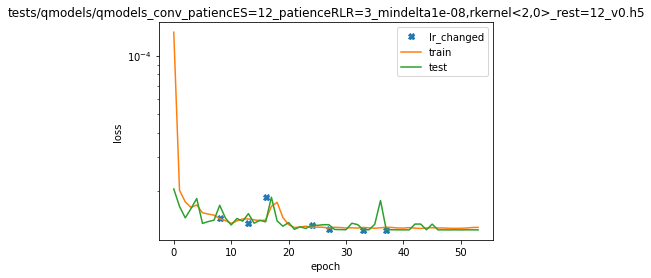

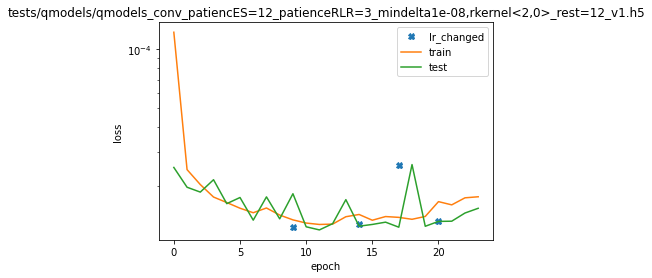

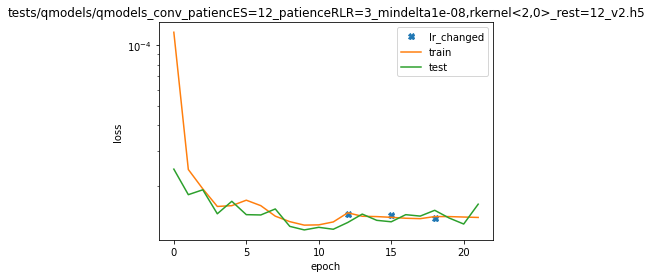

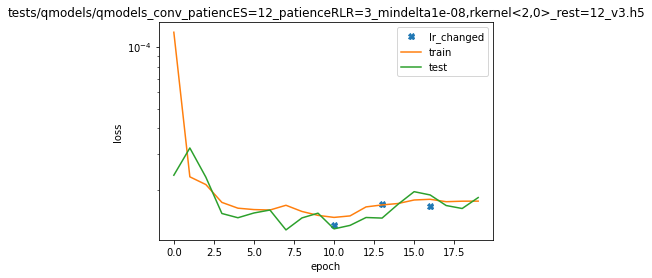

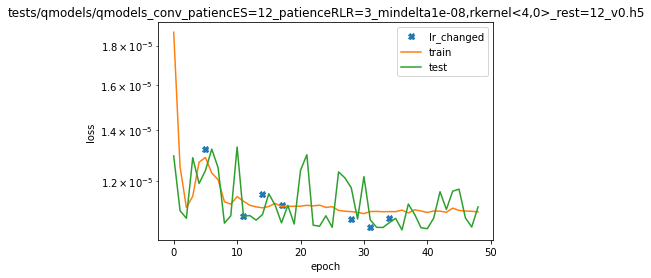

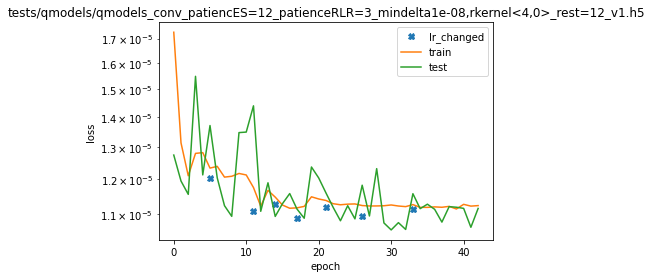

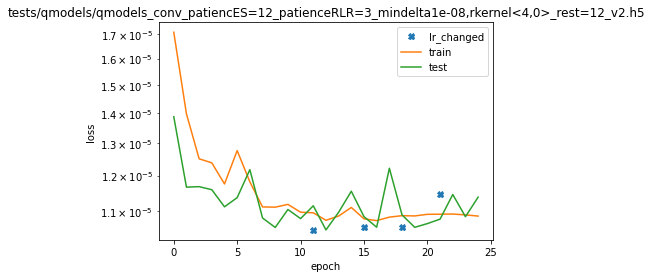

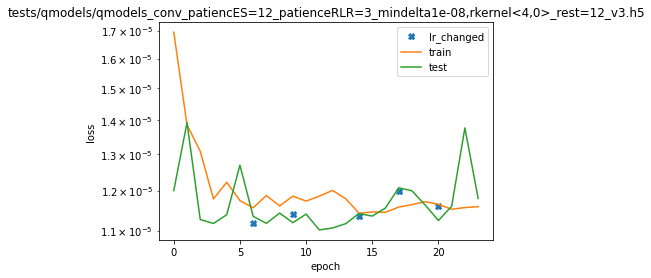

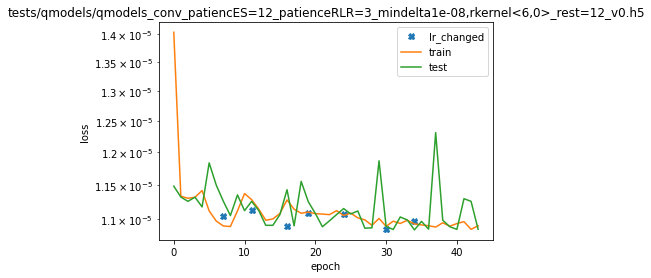

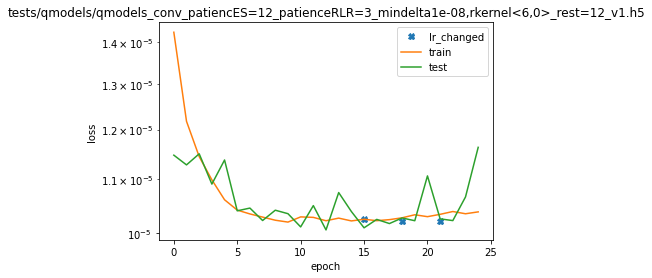

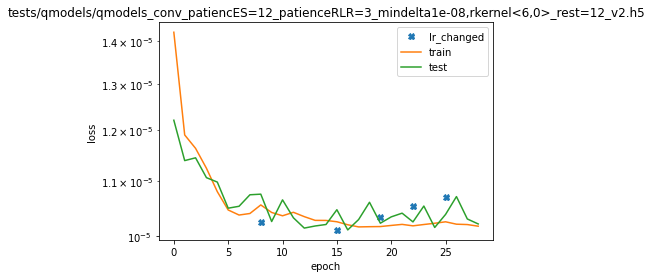

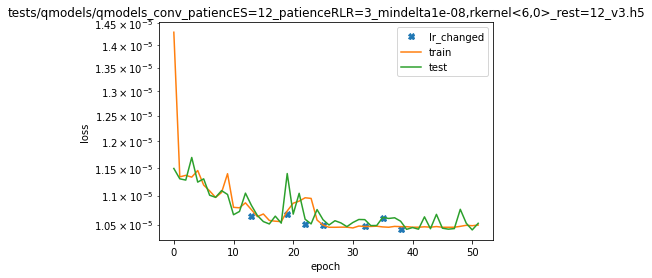

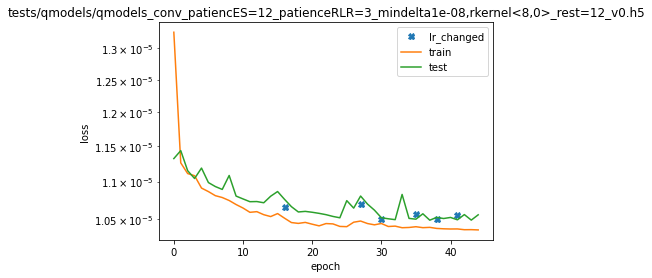

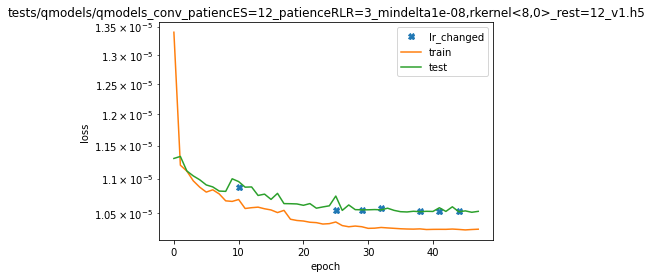

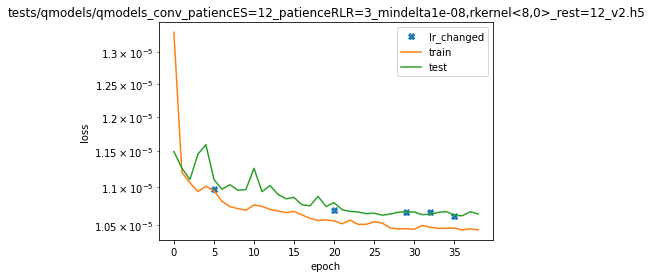

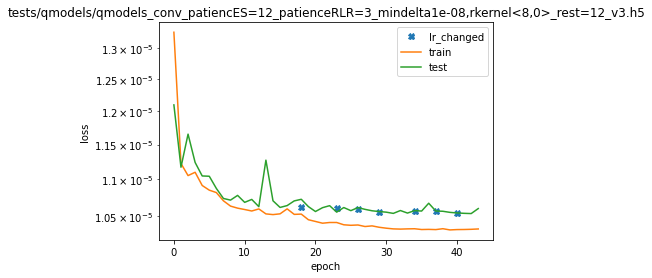

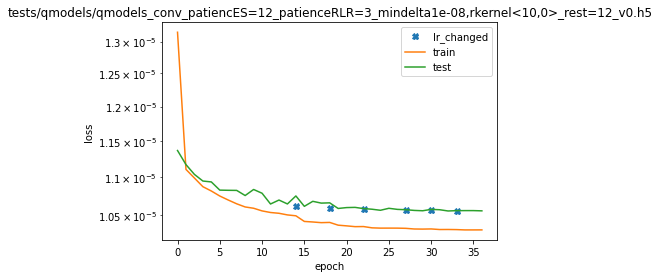

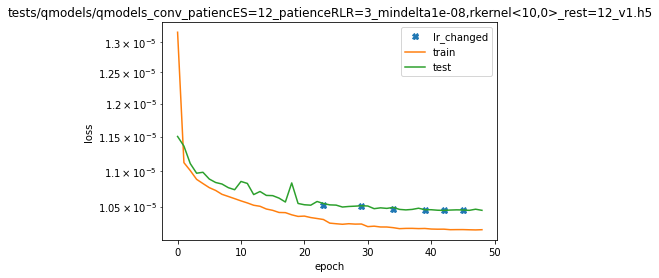

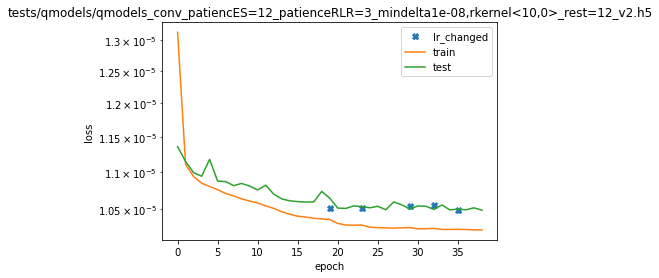

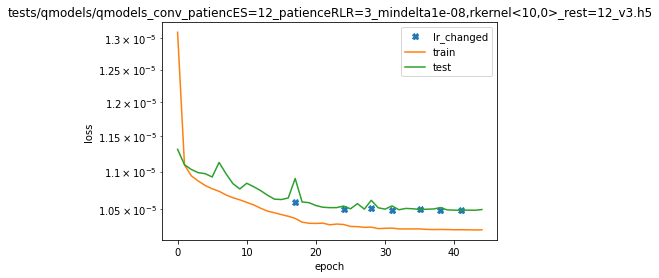

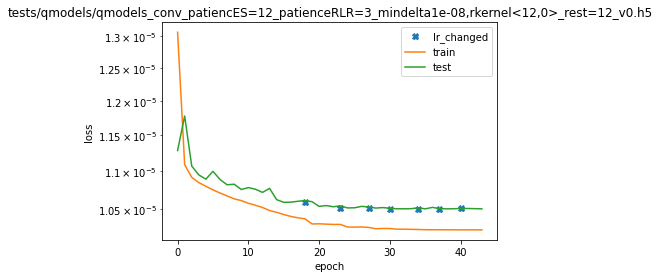

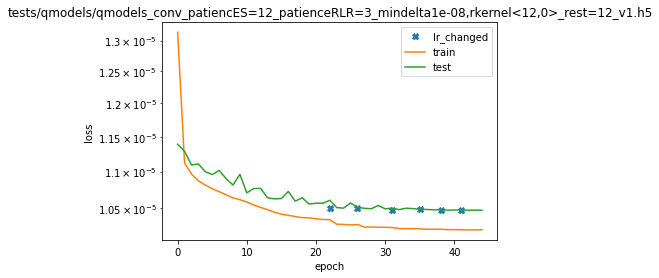

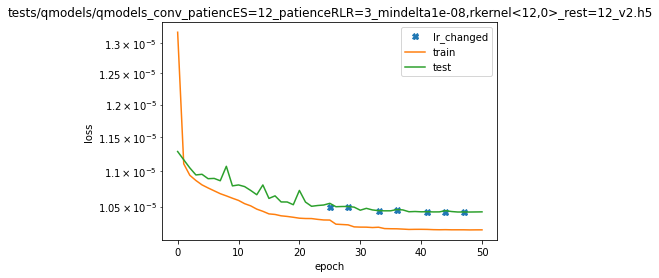

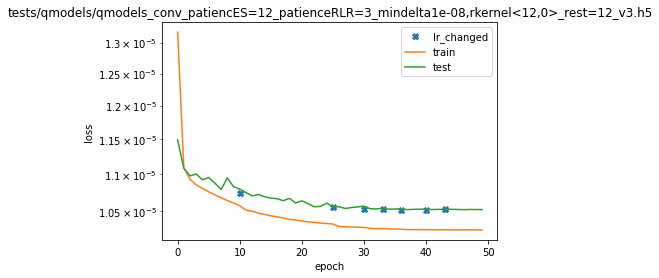

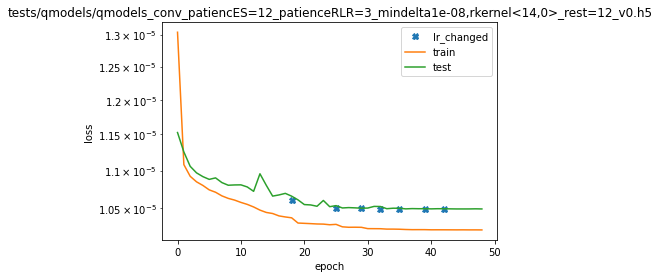

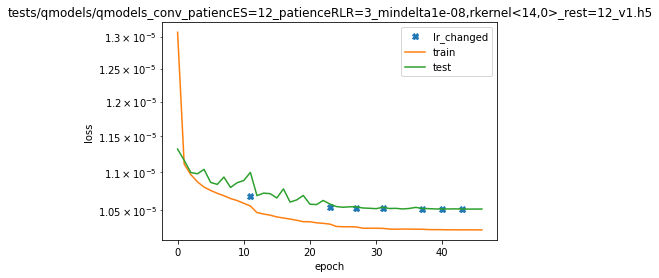

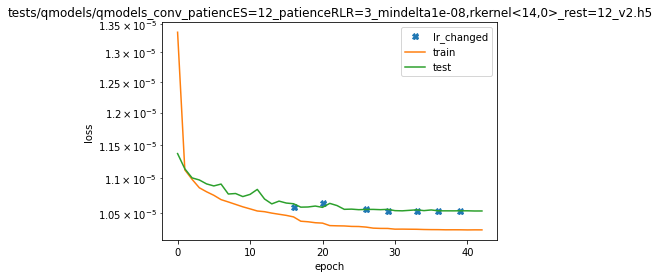

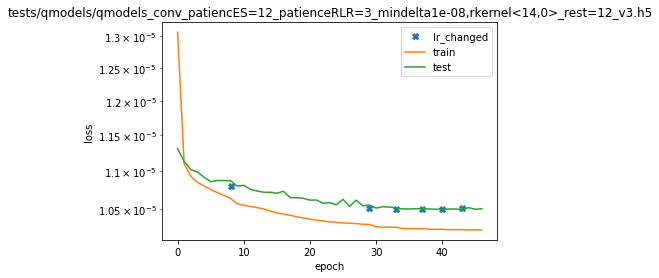

In [ ]:
for k in range (rest_units_range):
    for i in range (bits_range):
        for v in range (versions_range):
        
            
            file_to_read = open(qhist_path(i,v,k),"rb")
            hist = pickle.load(file_to_read)
            lr_change = []
            for a in range (len(hist['lr'])-1):
            
                if (hist['lr'][a]==hist['lr'][a+1]):
                    lr_change.append(None)
                else: 
                    lr_change.append(hist['val_loss'][a+1])
            plt.plot(lr_change, 'X')
            plt.plot(hist['loss'])
            plt.plot(hist['val_loss'])
            plt.title(qmodels_path0(i,v,k))
            plt.yscale('log')
            plt.ylabel('loss')
            plt.xlabel('epoch')
            plt.legend(['lr_changed','train', 'test'])
            plt.show()